# Autoencoder Dimensionality Redduction

### Load Libraries

In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
df_performance = pd.read_parquet("smda/project/data/random_50000_scores_performance.parquet")
df_quality = pd.read_parquet("smda/project/data/random_50000_scores_quality.parquet")

image_embedding_file = np.load("smda/project/data/image_embeddings.npz", allow_pickle=True)
image_embeddings = {k: image_embedding_file[k] for k in image_embedding_file.files}
title_embeddings = np.load("smda/project/data/title_embeddings.npz", allow_pickle=True)['arr_0'].item()

In [30]:
class VideoDataset(Dataset):
    def __init__(self, df, image_embeddings, title_embeddings, score_var, medium='image'):
        self.df = df
        self.image_embeddings = image_embeddings
        self.title_embeddings = title_embeddings
        self.score_var = score_var
        self.medium = medium

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = row['display_id']
        
        image_embedding = torch.tensor(self.image_embeddings[video_id], dtype=torch.float32)
        title_embedding = torch.tensor(self.title_embeddings[video_id], dtype=torch.float32)
        
        score = torch.tensor(row[self.score_var], dtype=torch.float32)
        
        if self.medium == 'image':
            embedding = image_embedding
        elif self.medium == 'title':
            embedding = title_embedding
        
        return embedding, video_id

In [31]:
# Autoencoder for dimensionality reduction
class AE2D(nn.Module):
    def __init__(self, embedding_dim):
        super(AE2D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # 2D bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

## Title

In [32]:
dataset_title = VideoDataset(df_performance, image_embeddings, title_embeddings, 'performance_score', medium='title')

dataloader_title = DataLoader(dataset_title, batch_size=128, shuffle=True)


def train_autoencoder(model, loader, optimizer, criterion):
    for epoch in range(10):
        model.train()
        total_loss = 0
        for x_batch, _ in loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            recon, z = model(x_batch)
            loss = criterion(recon, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")
        
title_dims = len(next(iter(title_embeddings.values())))
image_dims = len(next(iter(image_embeddings.values())))

model_title = AE2D(title_dims)
model_title.to(device)
optimizer = optim.Adam(model_title.parameters(), lr=1e-3)


criterion = nn.MSELoss()

train_autoencoder(model_title, dataloader_title, optimizer, criterion)


Epoch 1: Loss = 0.0006
Epoch 2: Loss = 0.0006
Epoch 3: Loss = 0.0006
Epoch 4: Loss = 0.0005
Epoch 5: Loss = 0.0005
Epoch 6: Loss = 0.0005
Epoch 7: Loss = 0.0005
Epoch 8: Loss = 0.0005
Epoch 9: Loss = 0.0005
Epoch 10: Loss = 0.0005


In [50]:
model_title.eval()

all_embeddings = []
all_video_ids = []

with torch.no_grad():
    for x_batch, video_ids in dataloader_title:
        x_batch = x_batch.to(device)
        _, embeddings_2d = model_title(x_batch)
        all_embeddings.append(embeddings_2d.cpu())
        all_video_ids.extend(video_ids)  # video_ids is a list of IDs for the batch

emb = torch.cat(all_embeddings, dim=0).numpy()

# create DataFrame with embeddings and video IDs
emb_df = pd.DataFrame(emb, columns=["dim1", "dim2"])
emb_df["video_id"] = all_video_ids

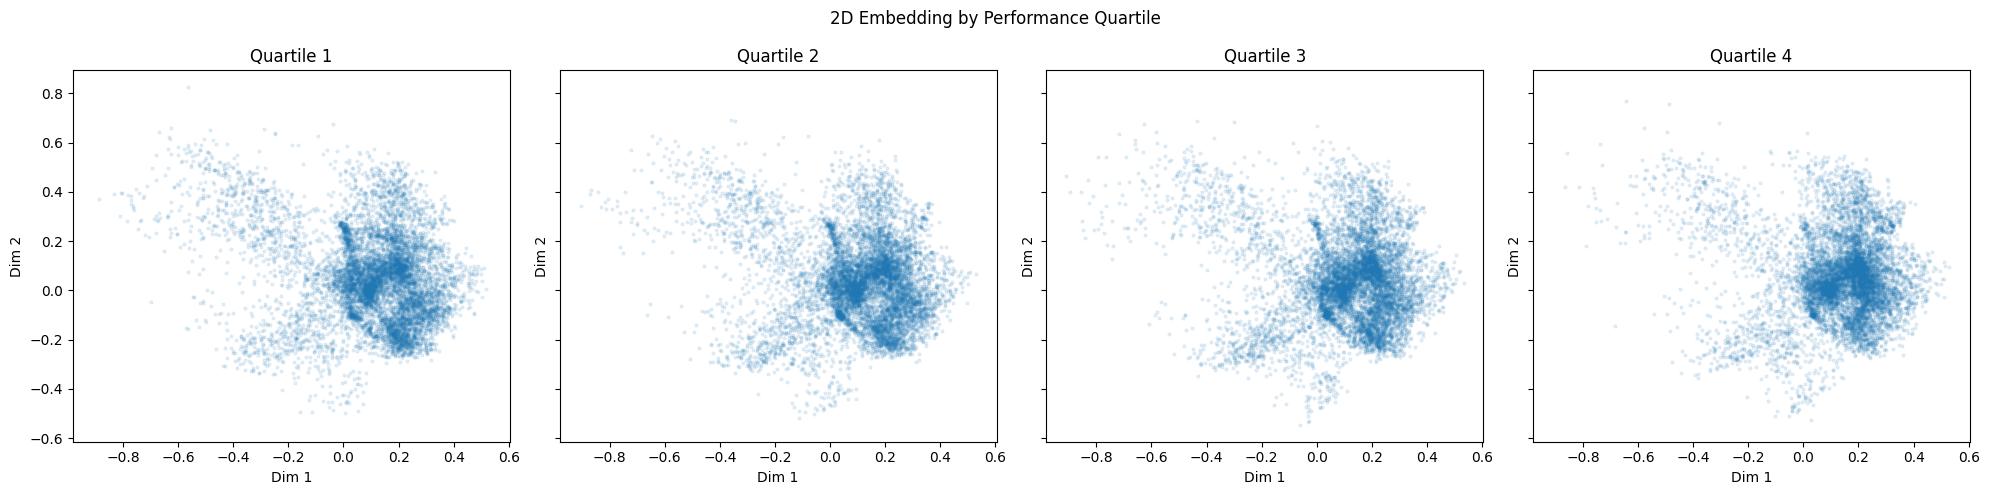

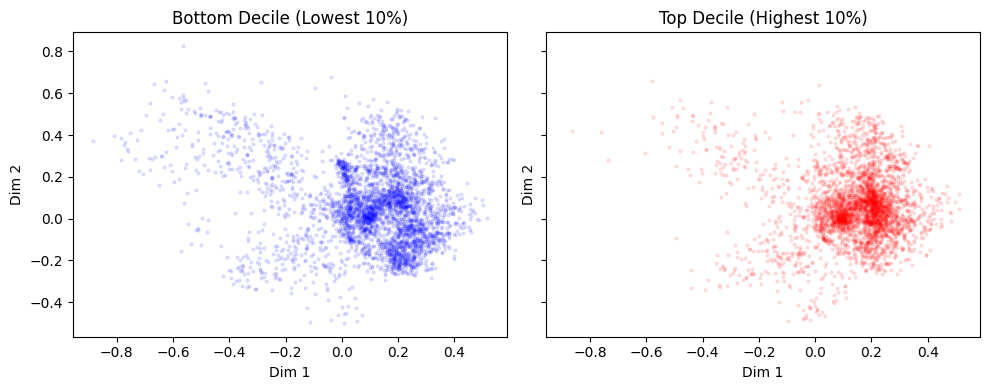

In [56]:
emb_df_performance = emb_df.merge(df_performance[['display_id', 'performance_score']], left_on='video_id', right_on='display_id', how='left')

# create quartiles of performance score
emb_df_performance['performance_quartile'] = pd.qcut(emb_df_performance['performance_score'], 4, labels=False)

# create visualization for each quartile
quartiles = emb_df_performance['performance_quartile'].unique()
n_quartiles = len(quartiles)

fig, axes = plt.subplots(1, n_quartiles, figsize=(5 * n_quartiles, 5), sharex=True, sharey=True)

for i, q in enumerate(sorted(quartiles)):
    ax = axes[i] if n_quartiles > 1 else axes
    subset = emb_df_performance[emb_df_performance['performance_quartile'] == q]
    sc = ax.scatter(subset['dim1'], subset['dim2'], s=4, alpha=0.1)
    ax.set_title(f"Quartile {int(q)+1}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")

plt.suptitle("2D Embedding by Performance Quartile")
plt.tight_layout()
plt.show()

emb_df_performance['performance_decile'] = pd.qcut(emb_df_performance['performance_score'], 10, labels=False)

# Filter for bottom and top decile
bottom_decile = emb_df_performance[emb_df_performance['performance_decile'] == 0]
top_decile = emb_df_performance[emb_df_performance['performance_decile'] == 9]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Bottom decile
axes[0].scatter(bottom_decile['dim1'], bottom_decile['dim2'], s=4, alpha=0.1, color='blue')
axes[0].set_title("Bottom Decile (Lowest 10%)")
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

# Top decile
axes[1].scatter(top_decile['dim1'], top_decile['dim2'], s=4, alpha=0.1, color='red')
axes[1].set_title("Top Decile (Highest 10%)")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

# plt.suptitle("2D Embedding: Top vs Bottom Decile of Performance Score")
plt.tight_layout()
plt.show()

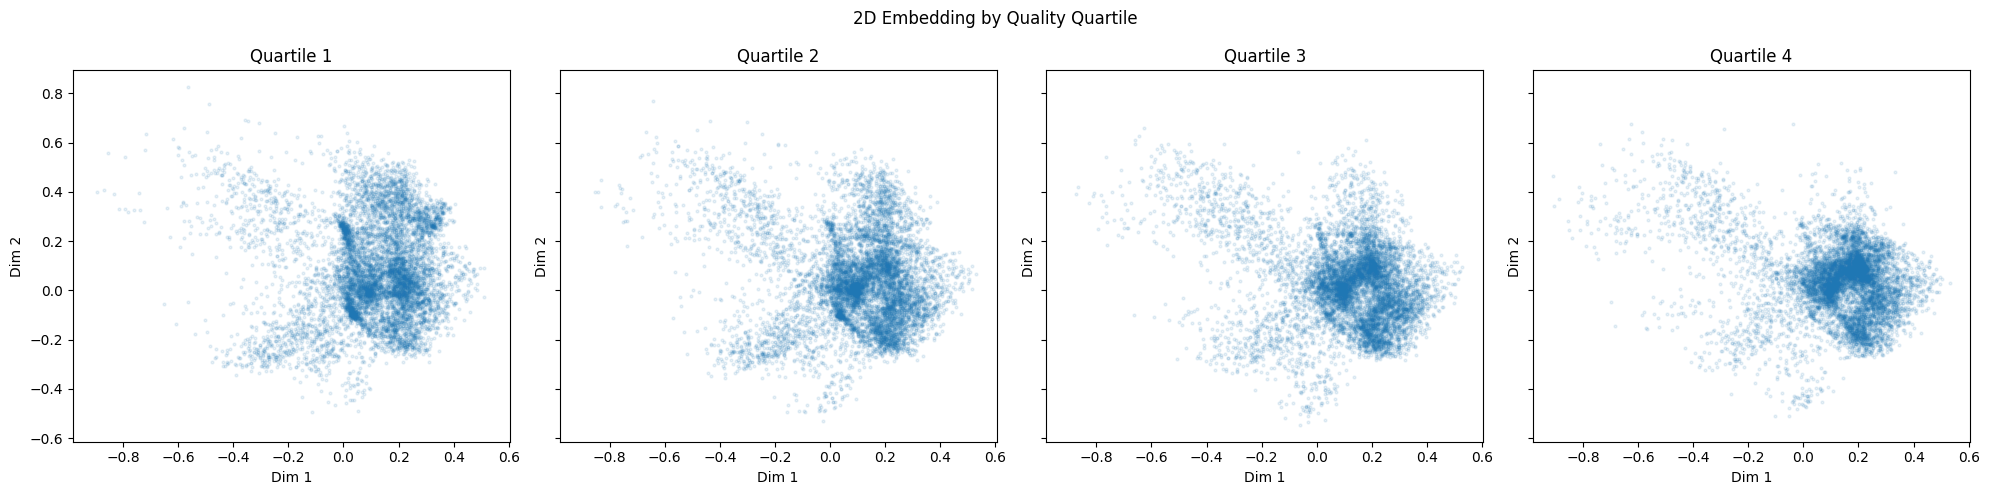

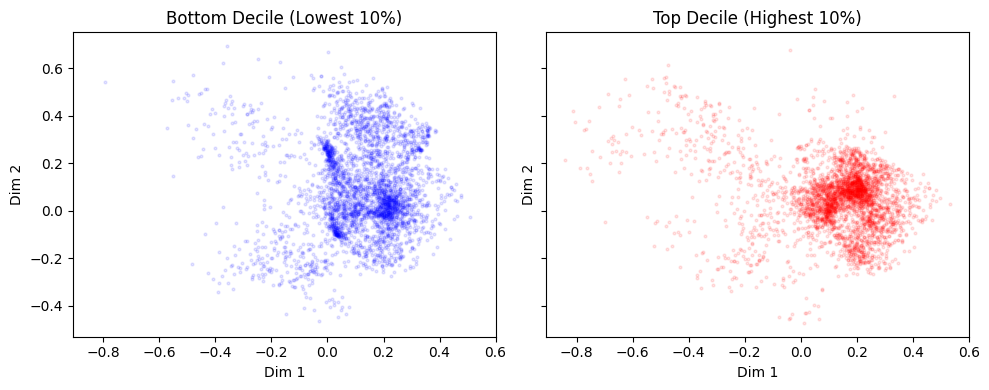

In [54]:
emb_df_quality = emb_df.merge(df_quality[['display_id', 'quality_score']], left_on='video_id', right_on='display_id', how='inner')

# create quartiles of quality score
emb_df_quality['quality_quartile'] = pd.qcut(emb_df_quality['quality_score'], 4, labels=False)

# create visualization for each quartile
quartiles = emb_df_quality['quality_quartile'].unique()
n_quartiles = len(quartiles)

fig, axes = plt.subplots(1, n_quartiles, figsize=(5 * n_quartiles, 5), sharex=True, sharey=True)

for i, q in enumerate(sorted(quartiles)):
    ax = axes[i] if n_quartiles > 1 else axes
    subset = emb_df_quality[emb_df_quality['quality_quartile'] == q]
    sc = ax.scatter(subset['dim1'], subset['dim2'], s=4, alpha=0.1)
    ax.set_title(f"Quartile {int(q)+1}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")

plt.suptitle("2D Embedding by Quality Quartile")
plt.tight_layout()
plt.show()

emb_df_quality['quality_decile'] = pd.qcut(emb_df_quality['quality_score'], 10, labels=False)

# filter for bottom and top decile
bottom_decile = emb_df_quality[emb_df_quality['quality_decile'] == 0]
top_decile = emb_df_quality[emb_df_quality['quality_decile'] == 9]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Bottom decile
axes[0].scatter(bottom_decile['dim1'], bottom_decile['dim2'], s=4, alpha=0.1, color='blue')
axes[0].set_title("Bottom Decile (Lowest 10%)")
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

# Top decile
axes[1].scatter(top_decile['dim1'], top_decile['dim2'], s=4, alpha=0.1, color='red')
axes[1].set_title("Top Decile (Highest 10%)")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

# plt.suptitle("2D Embedding: Top vs Bottom Decile of Quality Score")
plt.tight_layout()
plt.show()

## Thumbnail

In [40]:
dataset_image = VideoDataset(df_performance, image_embeddings, title_embeddings, 'performance_score', medium='image')

dataloader_image = DataLoader(dataset_image, batch_size=128, shuffle=True)

def train_autoencoder(model, loader, optimizer, criterion):
    model_image.train()
    for epoch in range(10):
        total_loss = 0
        for x_batch, _ in loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            recon, z = model(x_batch)
            loss = criterion(recon, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")
        
title_dims = len(next(iter(title_embeddings.values())))
image_dims = len(next(iter(image_embeddings.values())))

model_image = AE2D(image_dims)
model_image.to(device)
optimizer = optim.Adam(model_image.parameters(), lr=1e-3)

criterion = nn.MSELoss()

train_autoencoder(model_image, dataloader_image, optimizer, criterion)

Epoch 1: Loss = 0.0012
Epoch 2: Loss = 0.0010
Epoch 3: Loss = 0.0010
Epoch 4: Loss = 0.0010
Epoch 5: Loss = 0.0010
Epoch 6: Loss = 0.0010
Epoch 7: Loss = 0.0010
Epoch 8: Loss = 0.0010
Epoch 9: Loss = 0.0010
Epoch 10: Loss = 0.0010


In [57]:
model_image.eval()

all_embeddings = []
all_video_ids = []

with torch.no_grad():
    for x_batch, video_ids in dataloader_image:
        x_batch = x_batch.to(device)
        _, embeddings_2d = model_image(x_batch)
        all_embeddings.append(embeddings_2d.cpu())
        all_video_ids.extend(video_ids)  # video_ids is a list of IDs for the batch

emb = torch.cat(all_embeddings, dim=0).numpy()

# create DataFrame with embeddings and video IDs
emb_df = pd.DataFrame(emb, columns=["dim1", "dim2"])
emb_df["video_id"] = all_video_ids

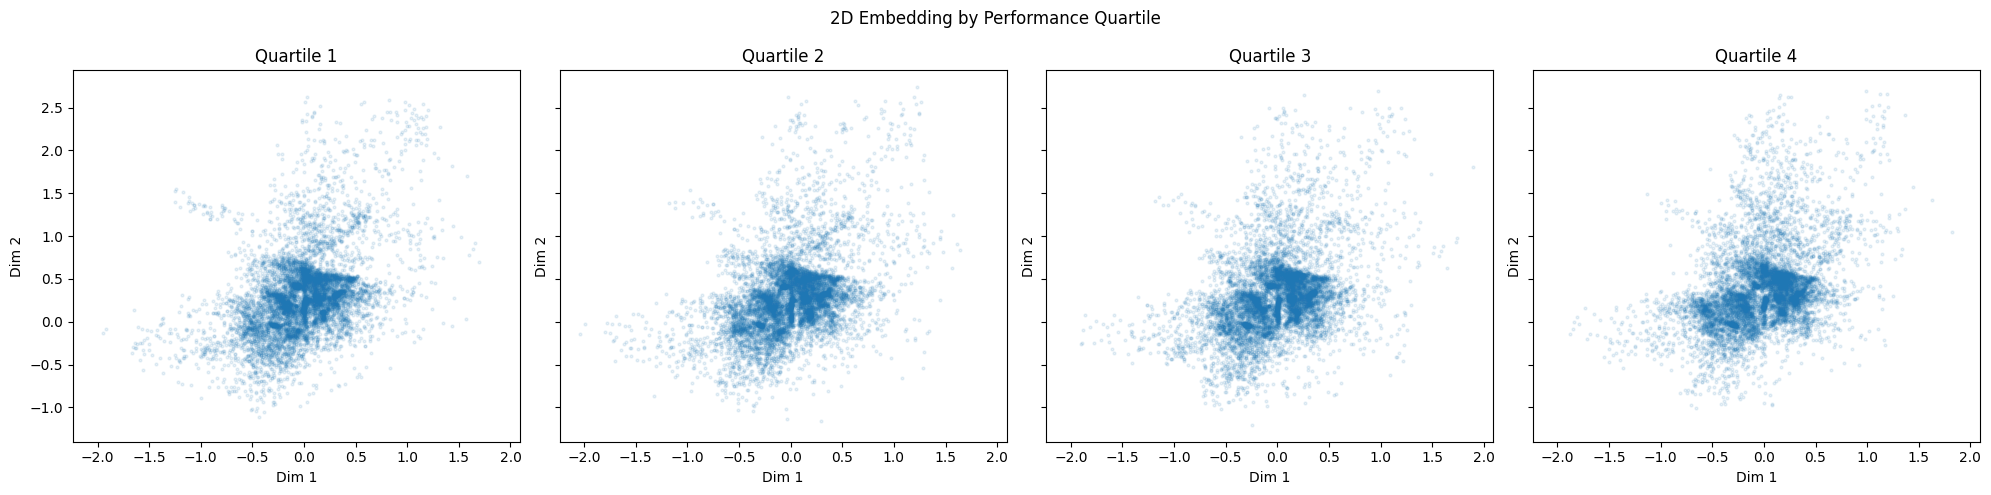

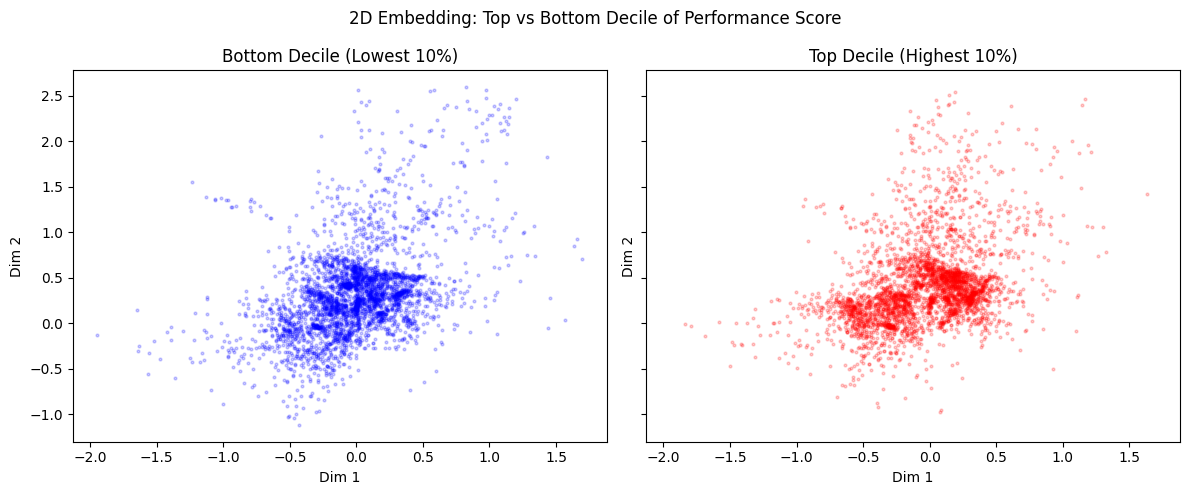

In [58]:
emb_df_performance = emb_df.merge(df_performance[['display_id', 'performance_score']], left_on='video_id', right_on='display_id', how='left')

# create quartiles of performance score
emb_df_performance['performance_quartile'] = pd.qcut(emb_df_performance['performance_score'], 4, labels=False)

# create visualization for each quartile
quartiles = emb_df_performance['performance_quartile'].unique()
n_quartiles = len(quartiles)

fig, axes = plt.subplots(1, n_quartiles, figsize=(5 * n_quartiles, 5), sharex=True, sharey=True)

for i, q in enumerate(sorted(quartiles)):
    ax = axes[i] if n_quartiles > 1 else axes
    subset = emb_df_performance[emb_df_performance['performance_quartile'] == q]
    sc = ax.scatter(subset['dim1'], subset['dim2'], s=4, alpha=0.1)
    ax.set_title(f"Quartile {int(q)+1}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")

plt.suptitle("2D Embedding by Performance Quartile")
plt.tight_layout()
plt.show()

emb_df_performance['performance_decile'] = pd.qcut(emb_df_performance['performance_score'], 10, labels=False)

bottom_decile = emb_df_performance[emb_df_performance['performance_decile'] == 0]
top_decile = emb_df_performance[emb_df_performance['performance_decile'] == 9]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Bottom decile
axes[0].scatter(bottom_decile['dim1'], bottom_decile['dim2'], s=4, alpha=0.2, color='blue')
axes[0].set_title("Bottom Decile (Lowest 10%)")
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

# Top decile
axes[1].scatter(top_decile['dim1'], top_decile['dim2'], s=4, alpha=0.2, color='red')
axes[1].set_title("Top Decile (Highest 10%)")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

plt.suptitle("2D Embedding: Top vs Bottom Decile of Performance Score")
plt.tight_layout()
plt.show()

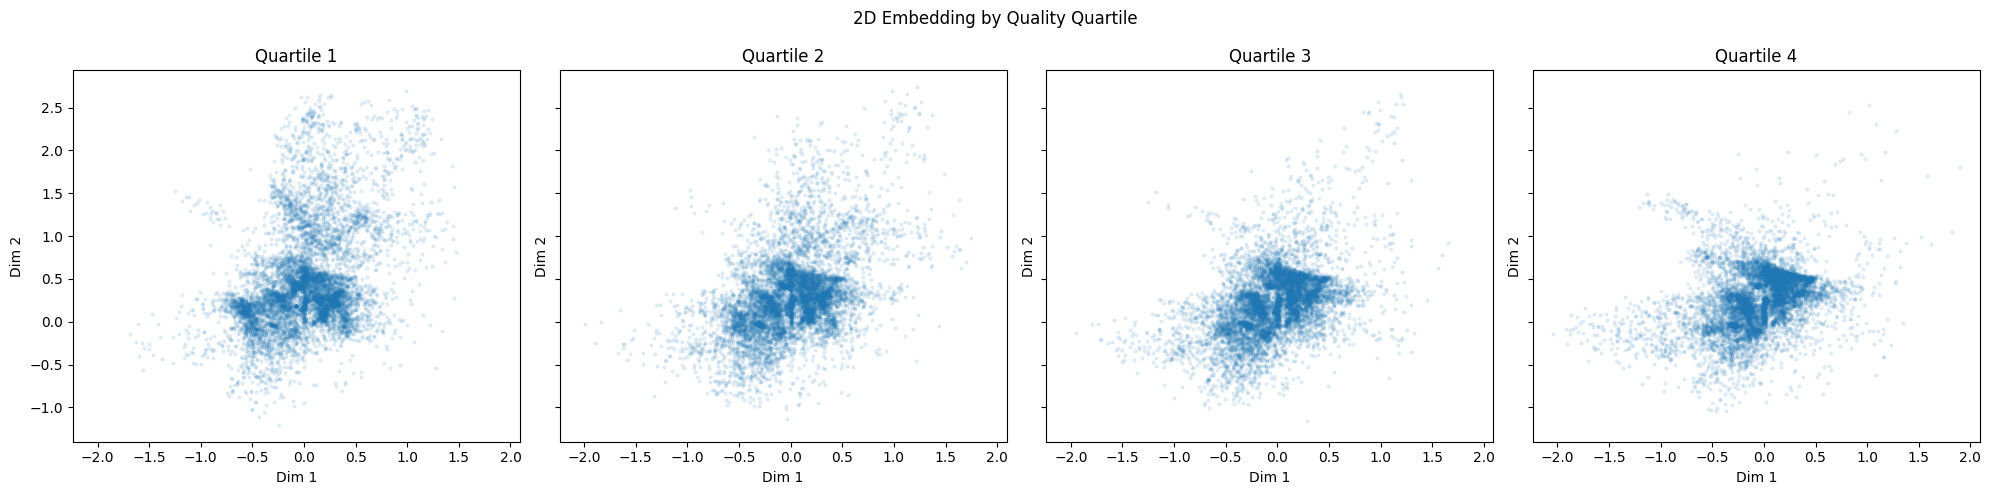

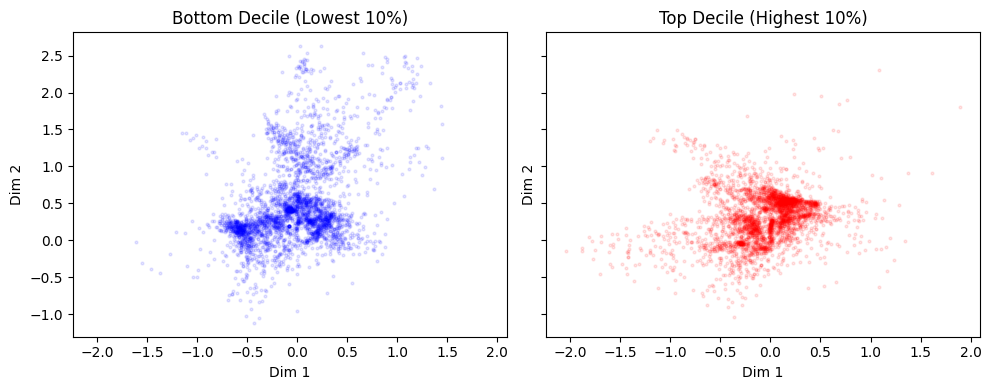

In [59]:
emb_df_quality = emb_df.merge(df_quality[['display_id', 'quality_score']], left_on='video_id', right_on='display_id', how='inner')

# create quartiles of quality score
emb_df_quality['quality_quartile'] = pd.qcut(emb_df_quality['quality_score'], 4, labels=False)

# create visualization for each quartile
quartiles = emb_df_quality['quality_quartile'].unique()
n_quartiles = len(quartiles)

fig, axes = plt.subplots(1, n_quartiles, figsize=(5 * n_quartiles, 5), sharex=True, sharey=True)

for i, q in enumerate(sorted(quartiles)):
    ax = axes[i] if n_quartiles > 1 else axes
    subset = emb_df_quality[emb_df_quality['quality_quartile'] == q]
    sc = ax.scatter(subset['dim1'], subset['dim2'], s=4, alpha=0.1)
    ax.set_title(f"Quartile {int(q)+1}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")

plt.suptitle("2D Embedding by Quality Quartile")
plt.tight_layout()
plt.show()

emb_df_quality['quality_decile'] = pd.qcut(emb_df_quality['quality_score'], 10, labels=False)

bottom_decile = emb_df_quality[emb_df_quality['quality_decile'] == 0]
top_decile = emb_df_quality[emb_df_quality['quality_decile'] == 9]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Bottom decile
axes[0].scatter(bottom_decile['dim1'], bottom_decile['dim2'], s=4, alpha=0.1, color='blue')
axes[0].set_title("Bottom Decile (Lowest 10%)")
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

# Top decile
axes[1].scatter(top_decile['dim1'], top_decile['dim2'], s=4, alpha=0.1, color='red')
axes[1].set_title("Top Decile (Highest 10%)")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

# plt.suptitle("2D Embedding: Top vs Bottom Decile of Quality Score")
plt.tight_layout()
plt.show()